In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Wed Feb 12 10:13:04 PST 2020


# Table with summary values and residuals

Epsilon (8 values); TC/SC (2 values); level (enum, county, state, national); <- stratification factors

Median value, 2.5% and 97.5th percentile of count; median absolute error, 2.5% and 97.5th percentile of error distribution; EPL




In [2]:
import dp_2020_census.data, dp_2020_census.model

In [3]:
import json
dname = '/ihme/homes/abie/projects/2019/dp_2020_census/'
with open(dname + 'results_dp_error.json') as f:
    results_dp_error = pd.Series(json.load(f))
    
with open(dname + 'results_dp_counts.json') as f:
    results_dp_counts = pd.Series(json.load(f))

with open(dname + 'results_dp_epl.json') as f:
    results_dp_epl = pd.Series(json.load(f))


In [4]:
epsilon_vals = '0.25 0.50 0.75 1.0 2.0 4.0 6.0 8.0'.split()
stratification_types = ['tc', 'sc']
geographic_levels = [#'nation',
                     'state', 'county', 'enum_dist',]

In [5]:
results = []

for epsilon in epsilon_vals:
    for s in stratification_types:
        for g in geographic_levels:
            r = dict(epsilon=epsilon, stratification_type=s, geographic_level=g)
            
            # Median value, 2.5% and 97.5th percentile of count
            r['count_median'] = results_dp_counts[f'{s}_{g}_count_median']  # median count
            r['count_pct95'] = results_dp_counts[f'{s}_{g}_count_pct95']  # 95th percentile count
            
            # Median absolute error, 2.5% and 97.5th percentile of error distribution.
            
            epsilon_underscore = epsilon.replace('.', '_')
            key = f'{s}_{g}_{epsilon_underscore}'

            r['error_median'] = results_dp_error[f'{key}_mae'] # Median Absolute Error (median of absolute value of residuals)
            r['error_pct95'] = results_dp_error[f'{key}_pct95'] # 95th percentile residual
            r['error_max_abs'] = results_dp_error[f'{key}_max_ae'] # maximum absolute residual
            
            key = f'{s}_privacy_loss_{g}_{epsilon_underscore}_max_abs'
            r['epl'] = results_dp_epl.get(key, np.inf)
            results.append(r)

In [6]:
# now make a nicely formatted version of that table
pd.DataFrame(results).groupby(['geographic_level', 'stratification_type',
                               'count_median', 'count_pct95',
                               'epsilon',
                               ]).first().dropna(subset=['epl'])

error_median  \
geographic_level stratification_type count_median count_pct95 epsilon                
county           sc                  47           17480       0.25              16   
                                                              0.50              11   
                                                              0.75               8   
                                                              1.0                6   
                                                              2.0                4   
...                                                                            ...   
state            tc                  1903133      7419040     1.0                0   
                                                              2.0                0   
                                                              4.0                0   
                                                              6.0                0   
                                                              8.0                0   

                                                                      error_pct95  \
geographic_level stratification_type count_median count_pct95 epsilon               
county           sc                  47           17480       0.25            107   
                                                              0.50             56   
                                                              0.75             38   
                                                              1.0              29   
                                                              2.0              15   
...                                                                           ...   
state            tc                  1903133      7419040     1.0               0   
                                                              2.0               0   
                                                              4.0               0   
                                                              6.0               0   
                                                              8.0               0   

                                                                      error_max_abs  \
geographic_level stratification_type count_median count_pct95 epsilon                 
county           sc                  47           17480       0.25              431   
                                                              0.50              298   
                                                              0.75              160   
                                                              1.0               165   
                                                              2.0                73   
...                                                                             ...   
state            tc                  1903133      7419040     1.0                 0   
                                                              2.0                 0   
                                                              4.0                 0   
                                                              6.0                 0   
                                                              8.0                 0   

                                                                         epl  
geographic_level stratification_type count_median count_pct95 epsilon         
county           sc                  47           17480       0.25     0.126  
                                                              0.50     0.165  
                                                              0.75     0.150  
                                                              1.0      0.164  
                                                              2.0      0.253  
...                                                                      ...  
state            tc                  1903133      7419040     1.0        inf  
  

In [7]:
df = pd.DataFrame(results).loc[:, ['geographic_level', 'stratification_type',
                               'epsilon',
                              'count_median', 'count_pct95',
                               'error_median', 'error_pct95', 'error_max_abs', 'epl'
                               ]]
df

,geographic_level,stratification_type,epsilon,count_median,count_pct95,error_median,error_pct95,error_max_abs,epl
0,state,tc,0.25,1903133,7419040,0,0,0,inf
1,county,tc,0.25,18679,122710,81,277,1020,0.014
2,enum_dist,tc,0.25,865,2342,56,190,688,0.017
3,state,sc,0.25,229,714208,18,110,348,0.119
4,county,sc,0.25,47,17480,16,107,431,0.126
...,...,...,...,...,...,...,...,...,...
43,county,tc,8.0,18679,122710,4,12,185,0.318
44,enum_dist,tc,8.0,865,2342,2,7,39,0.381
45,state,sc,8.0,229,714208,1,4,9,0.742
46,county,sc,8.0,47,17480,1,4,24,0.722


In [8]:
df.to_excel('sup_table.xlsx', )  # TODO: format this nicely 

In [9]:
df['eps_float'] = df.epsilon.astype(float)
df['epl_float'] = df.epl.astype(float)

In [10]:
def my_line_of_equivalence(color):
    plt.plot([.25,8],[.25,8], 'k--', zorder=0)

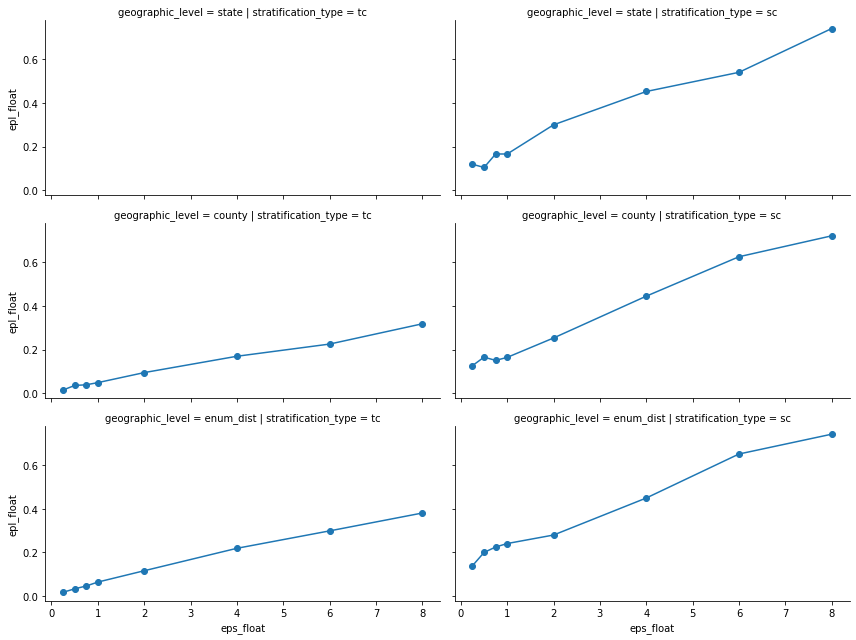

In [11]:
import seaborn as sns
g = sns.FacetGrid(df, row='geographic_level', col='stratification_type', aspect=2)
g.map(plt.plot, 'eps_float', 'epl_float', marker='o')
# g.map(my_line_of_equivalence)